In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
# Clinical Trial Stroke Risk Prediction - Synthetic Data Generator
# Designed for Kaggle Notebook Environment

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("=== Clinical Trial Stroke Risk Prediction Data Generator ===")
print("Creating synthetic data following FDA CDISC standards\n")

# =============================================================================
# 1. Generate Demographics (DM) Table
# =============================================================================

def generate_demographics(n_subjects=1000):
    """Generate demographic data following CDISC DM domain"""
    
    subjects = []
    for i in range(1, n_subjects + 1):
        subject = {
            'SUBJID': f'SUBJ{i:04d}',
            'AGE': np.random.normal(65, 12),  # Mean age 65, SD 12
            'SEX': np.random.choice(['M', 'F'], p=[0.48, 0.52]),
            'RACE': np.random.choice(['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER'], 
                                   p=[0.6, 0.15, 0.15, 0.08, 0.02]),
            'ARM': np.random.choice(['TREATMENT', 'CONTROL'], p=[0.5, 0.5]),
            'RFSTDTC': datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 365))
        }
        
        # Ensure age is within reasonable range
        subject['AGE'] = max(18, min(95, subject['AGE']))
        subjects.append(subject)
    
    df_dm = pd.DataFrame(subjects)
    df_dm['AGE'] = df_dm['AGE'].round(0).astype(int)
    
    print(f"✓ Generated demographics data for {len(df_dm)} subjects")
    return df_dm

# =============================================================================
# 2. Generate Vital Signs (VS) Table
# =============================================================================

def generate_vital_signs(df_dm, visits_per_subject=6):
    """Generate vital signs data following CDISC VS domain"""
    
    vs_records = []
    
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        age = subject['AGE']
        sex = subject['SEX']
        
        # Baseline values (adjusted for age and gender)
        base_sbp = 120 + (age - 50) * 0.5 + (10 if sex == 'M' else 0)
        base_dbp = 80 + (age - 50) * 0.3 + (5 if sex == 'M' else 0)
        base_hr = 70 + np.random.normal(0, 5)
        base_temp = 36.5 + np.random.normal(0, 0.3)
        base_weight = 70 + (10 if sex == 'M' else -5) + np.random.normal(0, 8)
        
        for visit in range(1, visits_per_subject + 1):
            visit_date = subject['RFSTDTC'] + timedelta(days=visit * 30)
            
            # Add time trend and random variation
            trend_factor = 1 + (visit - 1) * 0.02  # Slight deterioration trend
            
            vs_records.extend([
                {
                    'SUBJID': subjid,
                    'VSTESTCD': 'SYSBP',
                    'VSTEST': 'Systolic Blood Pressure',
                    'VSORRES': max(90, base_sbp * trend_factor + np.random.normal(0, 8)),
                    'VSORRESU': 'mmHg',
                    'VSDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'VSTESTCD': 'DIABP',
                    'VSTEST': 'Diastolic Blood Pressure', 
                    'VSORRES': max(60, base_dbp * trend_factor + np.random.normal(0, 5)),
                    'VSORRESU': 'mmHg',
                    'VSDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'VSTESTCD': 'HR',
                    'VSTEST': 'Heart Rate',
                    'VSORRES': max(50, base_hr + np.random.normal(0, 8)),
                    'VSORRESU': 'beats/min',
                    'VSDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'VSTESTCD': 'TEMP',
                    'VSTEST': 'Temperature',
                    'VSORRES': base_temp + np.random.normal(0, 0.2),
                    'VSORRESU': 'C',
                    'VSDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'VSTESTCD': 'WEIGHT',
                    'VSTEST': 'Weight',
                    'VSORRES': max(40, base_weight + np.random.normal(0, 2)),
                    'VSORRESU': 'kg',
                    'VSDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                }
            ])
    
    df_vs = pd.DataFrame(vs_records)
    df_vs['VSORRES'] = df_vs['VSORRES'].round(1)
    
    print(f"✓ Generated {len(df_vs)} vital signs records")
    return df_vs

# =============================================================================
# 3. Generate Laboratory (LB) Table
# =============================================================================

def generate_lab_data(df_dm, visits_per_subject=6):
    """Generate laboratory data following CDISC LB domain"""
    
    lb_records = []
    
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        age = subject['AGE']
        
        # Baseline laboratory values
        base_glucose = 100 + np.random.normal(0, 15)
        base_cholesterol = 200 + (age - 50) * 1.5 + np.random.normal(0, 30)
        base_hdl = 50 + np.random.normal(0, 10)
        base_ldl = 130 + np.random.normal(0, 25)
        base_triglycerides = 150 + np.random.normal(0, 40)
        base_creatinine = 1.0 + np.random.normal(0, 0.2)
        
        for visit in range(1, visits_per_subject + 1):
            visit_date = subject['RFSTDTC'] + timedelta(days=visit * 30)
            
            lb_records.extend([
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'GLUCOSE',
                    'LBTEST': 'Glucose',
                    'LBORRES': max(70, base_glucose + np.random.normal(0, 10)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'CHOL',
                    'LBTEST': 'Total Cholesterol',
                    'LBORRES': max(120, base_cholesterol + np.random.normal(0, 15)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'HDL',
                    'LBTEST': 'HDL Cholesterol',
                    'LBORRES': max(25, base_hdl + np.random.normal(0, 8)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'LDL',
                    'LBTEST': 'LDL Cholesterol',
                    'LBORRES': max(50, base_ldl + np.random.normal(0, 20)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'TRIG',
                    'LBTEST': 'Triglycerides',
                    'LBORRES': max(50, base_triglycerides + np.random.normal(0, 30)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                },
                {
                    'SUBJID': subjid,
                    'LBTESTCD': 'CREAT',
                    'LBTEST': 'Creatinine',
                    'LBORRES': max(0.5, base_creatinine + np.random.normal(0, 0.1)),
                    'LBORRESU': 'mg/dL',
                    'LBDTC': visit_date,
                    'VISIT': f'VISIT_{visit}'
                }
            ])
    
    df_lb = pd.DataFrame(lb_records)
    df_lb['LBORRES'] = df_lb['LBORRES'].round(2)
    
    print(f"✓ Generated {len(df_lb)} laboratory records")
    return df_lb

# =============================================================================
# 4. Generate Stroke Outcomes (based on risk factors)
# =============================================================================

def generate_stroke_outcomes(df_dm, df_vs, df_lb):
    """Generate stroke outcomes based on clinical risk factors"""
    
    outcomes = []
    
    # Get average values for each subject
    vs_summary = df_vs.groupby('SUBJID').agg({
        'VSORRES': ['mean', 'std']
    }).reset_index()
    vs_summary.columns = ['SUBJID', 'VS_MEAN', 'VS_STD']
    
    # Pivot vital signs data
    vs_pivot = df_vs.pivot_table(
        index='SUBJID', 
        columns='VSTESTCD', 
        values='VSORRES', 
        aggfunc='mean'
    ).reset_index()
    
    # Pivot laboratory data
    lb_pivot = df_lb.pivot_table(
        index='SUBJID',
        columns='LBTESTCD', 
        values='LBORRES',
        aggfunc='mean'
    ).reset_index()
    
    # Merge all data
    merged_data = df_dm.merge(vs_pivot, on='SUBJID', how='left')
    merged_data = merged_data.merge(lb_pivot, on='SUBJID', how='left')
    
    for _, row in merged_data.iterrows():
        # Calculate stroke risk score
        risk_score = 0
        
        # Age risk (most important factor)
        if row['AGE'] > 65:
            risk_score += (row['AGE'] - 65) * 0.1
            
        # Blood pressure risk
        if 'SYSBP' in row and pd.notna(row['SYSBP']):
            if row['SYSBP'] > 140:
                risk_score += (row['SYSBP'] - 140) * 0.05
                
        # Cholesterol risk  
        if 'CHOL' in row and pd.notna(row['CHOL']):
            if row['CHOL'] > 240:
                risk_score += (row['CHOL'] - 240) * 0.02
                
        # Gender risk (higher risk for males)
        if row['SEX'] == 'M':
            risk_score += 1.5
            
        # Race risk
        if row['RACE'] == 'BLACK':
            risk_score += 1.0
            
        # Diabetes risk
        if 'GLUCOSE' in row and pd.notna(row['GLUCOSE']):
            if row['GLUCOSE'] > 126:
                risk_score += 2.0
        
        # Treatment effect
        if row['ARM'] == 'TREATMENT':
            risk_score *= 0.8  # 20% risk reduction
            
        # Convert to probability using logistic function
        probability = 1 / (1 + np.exp(-(risk_score - 5)))
        
        # Determine stroke occurrence based on probability
        stroke = np.random.random() < probability
        
        outcomes.append({
            'SUBJID': row['SUBJID'],
            'STROKE': int(stroke),
            'RISK_SCORE': round(risk_score, 2),
            'STROKE_PROBABILITY': round(probability, 3)
        })
    
    df_outcomes = pd.DataFrame(outcomes)
    stroke_rate = df_outcomes['STROKE'].mean()
    
    print(f"✓ Generated stroke outcomes, stroke rate: {stroke_rate:.1%}")
    return df_outcomes

# =============================================================================
# 5. Generate Adverse Events (AE) Table  
# =============================================================================

def generate_adverse_events(df_dm, df_outcomes):
    """Generate adverse events data following CDISC AE domain"""
    
    ae_records = []
    
    # Common adverse events in cardiovascular studies
    ae_terms = [
        'HYPERTENSION', 'DIZZINESS', 'HEADACHE', 'FATIGUE', 
        'NAUSEA', 'CHEST PAIN', 'PALPITATIONS', 'EDEMA',
        'SHORTNESS OF BREATH', 'MUSCLE CRAMPS'
    ]
    
    ae_severity = ['MILD', 'MODERATE', 'SEVERE']
    ae_outcomes = ['RECOVERED/RESOLVED', 'RECOVERING/RESOLVING', 'NOT RECOVERED/NOT RESOLVED']
    
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        
        # Number of AEs per subject (Poisson distribution)
        n_aes = np.random.poisson(2)
        
        for ae_num in range(n_aes):
            ae_start = subject['RFSTDTC'] + timedelta(days=np.random.randint(1, 365))
            
            ae_records.append({
                'SUBJID': subjid,
                'AESEQ': ae_num + 1,
                'AETERM': np.random.choice(ae_terms),
                'AESTDTC': ae_start,
                'AESEV': np.random.choice(ae_severity, p=[0.6, 0.3, 0.1]),
                'AEOUT': np.random.choice(ae_outcomes, p=[0.7, 0.2, 0.1]),
                'AEREL': np.random.choice(['NOT RELATED', 'UNLIKELY', 'POSSIBLE', 'PROBABLE'], 
                                       p=[0.4, 0.3, 0.2, 0.1])
            })
    
    df_ae = pd.DataFrame(ae_records)
    
    print(f"✓ Generated {len(df_ae)} adverse event records")
    return df_ae

# =============================================================================
# 6. Generate Exposure (EX) Table
# =============================================================================

def generate_exposure_data(df_dm):
    """Generate exposure data following CDISC EX domain"""
    
    ex_records = []
    
    for _, subject in df_dm.iterrows():
        subjid = subject['SUBJID']
        treatment = subject['ARM']
        
        if treatment == 'TREATMENT':
            drug_name = 'STUDY DRUG'
            dose = '10 mg'
            route = 'ORAL'
        else:
            drug_name = 'PLACEBO'
            dose = 'N/A'
            route = 'ORAL'
        
        # Treatment duration (most complete study, some early discontinuation)
        max_duration = 365
        actual_duration = min(max_duration, 
                            np.random.exponential(300))  # Some early discontinuation
        
        start_date = subject['RFSTDTC']
        end_date = start_date + timedelta(days=int(actual_duration))
        
        ex_records.append({
            'SUBJID': subjid,
            'EXTRT': drug_name,
            'EXDOSE': dose,
            'EXDOSU': 'mg' if dose != 'N/A' else '',
            'EXROUTE': route,
            'EXSTDTC': start_date,
            'EXENDTC': end_date,
            'EXDUR': int(actual_duration)
        })
    
    df_ex = pd.DataFrame(ex_records)
    
    print(f"✓ Generated {len(df_ex)} exposure records")
    return df_ex

# =============================================================================
# 7. Execute Data Generation
# =============================================================================

if __name__ == "__main__":
    # Generate all data tables
    print("Starting synthetic clinical trial data generation...\n")
    
    df_dm = generate_demographics(n_subjects=1000)
    df_vs = generate_vital_signs(df_dm, visits_per_subject=4)  
    df_lb = generate_lab_data(df_dm, visits_per_subject=4)
    df_outcomes = generate_stroke_outcomes(df_dm, df_vs, df_lb)
    df_ae = generate_adverse_events(df_dm, df_outcomes)
    df_ex = generate_exposure_data(df_dm)
    
    print(f"\n=== Data Generation Complete ===")
    print(f"Demographics (DM): {len(df_dm)} records")
    print(f"Vital Signs (VS): {len(df_vs)} records") 
    print(f"Laboratory (LB): {len(df_lb)} records")
    print(f"Adverse Events (AE): {len(df_ae)} records")
    print(f"Exposure (EX): {len(df_ex)} records")
    print(f"Outcomes: {len(df_outcomes)} records")
    
    # Display data overview
    print("\n=== Data Overview ===")
    print("\n1. Demographics (DM):")
    print(df_dm.head())
    
    print("\n2. Vital Signs (VS) - First 10 records:")
    print(df_vs.head(10))
    
    print("\n3. Laboratory (LB) - First 10 records:")
    print(df_lb.head(10))
    
    print("\n4. Stroke Outcomes:")
    print(df_outcomes.head())
    
    # Save data (automatically saved to working directory in Kaggle)
    df_dm.to_csv('demographics.csv', index=False)
    df_vs.to_csv('vital_signs.csv', index=False)  
    df_lb.to_csv('laboratory.csv', index=False)
    df_ae.to_csv('adverse_events.csv', index=False)
    df_ex.to_csv('exposure.csv', index=False)
    df_outcomes.to_csv('stroke_outcomes.csv', index=False)
    
    print("\n✓ All data saved as CSV files")
    print("\nNext step: Start feature engineering and model building!")

=== Clinical Trial Stroke Risk Prediction Data Generator ===
Creating synthetic data following FDA CDISC standards

Starting synthetic clinical trial data generation...

✓ Generated demographics data for 1000 subjects
✓ Generated 20000 vital signs records
✓ Generated 24000 laboratory records
✓ Generated stroke outcomes, stroke rate: 5.9%
✓ Generated 2045 adverse event records
✓ Generated 1000 exposure records

=== Data Generation Complete ===
Demographics (DM): 1000 records
Vital Signs (VS): 20000 records
Laboratory (LB): 24000 records
Adverse Events (AE): 2045 records
Exposure (EX): 1000 records
Outcomes: 1000 records

=== Data Overview ===

1. Demographics (DM):
     SUBJID  AGE SEX      RACE        ARM    RFSTDTC
0  SUBJ0001   71   F     WHITE  TREATMENT 2023-08-03
1  SUBJ0002   63   M     ASIAN    CONTROL 2023-06-01
2  SUBJ0003   59   F  HISPANIC  TREATMENT 2023-10-04
3  SUBJ0004   67   F     BLACK  TREATMENT 2023-12-11
4  SUBJ0005   75   M     WHITE  TREATMENT 2023-07-09

2. Vital

=== Data Quality Assessment ===
DM: 0 missing values
VS: 0 missing values
LB: 0 missing values
AE: 0 missing values
EX: 0 missing values
Outcomes: 0 missing values


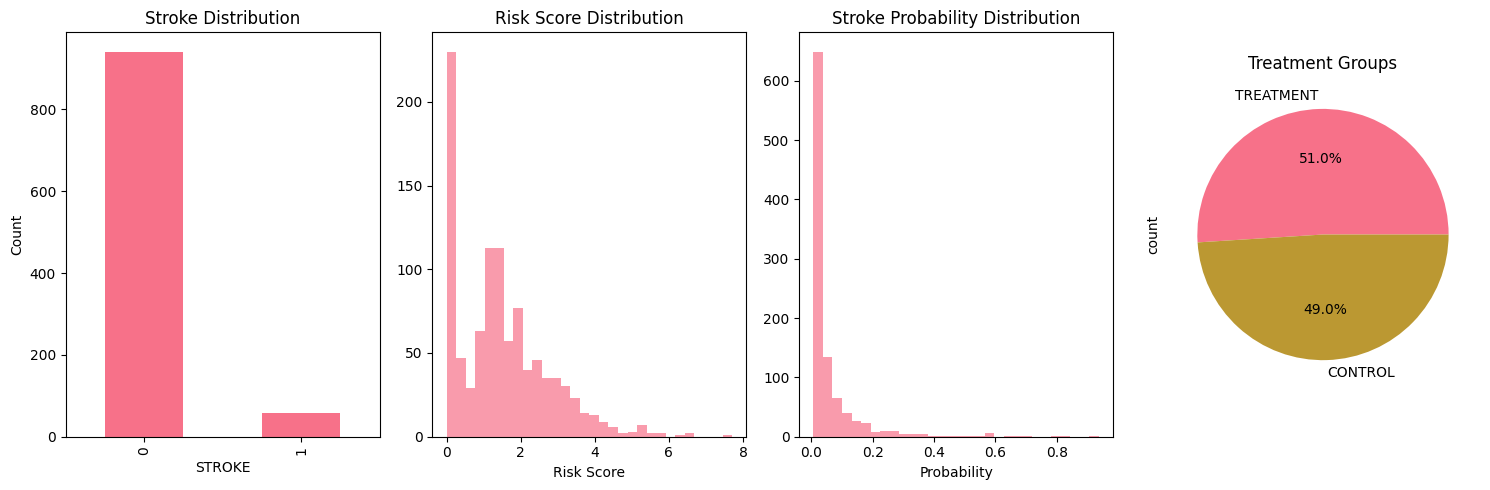


Stroke Rate by Treatment Group:
           count  sum      mean
ARM                            
CONTROL      490   35  0.071429
TREATMENT    510   24  0.047059


In [9]:
# Data Quality Validation
print("=== Data Quality Assessment ===")

# Check for missing values
datasets = [('DM', df_dm), ('VS', df_vs), ('LB', df_lb), 
           ('AE', df_ae), ('EX', df_ex), ('Outcomes', df_outcomes)]

for name, df in datasets:
    missing = df.isnull().sum().sum()
    print(f"{name}: {missing} missing values")

# Stroke risk distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
df_outcomes['STROKE'].value_counts().plot(kind='bar')
plt.title('Stroke Distribution')
plt.ylabel('Count')

plt.subplot(1, 4, 2)  
plt.hist(df_outcomes['RISK_SCORE'], bins=30, alpha=0.7)
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')

plt.subplot(1, 4, 3)
plt.hist(df_outcomes['STROKE_PROBABILITY'], bins=30, alpha=0.7)
plt.title('Stroke Probability Distribution')
plt.xlabel('Probability')

plt.subplot(1, 4, 4)
df_dm['ARM'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Treatment Groups')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nStroke Rate by Treatment Group:")
stroke_by_arm = df_dm.merge(df_outcomes, on='SUBJID')[['ARM', 'STROKE']].groupby('ARM')['STROKE'].agg(['count', 'sum', 'mean'])
print(stroke_by_arm)

=== Clinical Data Sanity Check & Model Evaluation ===

✓ Loaded generated clinical data
Preparing modeling dataset...
✓ Modeling dataset prepared: 1000 subjects, 20 features
Available features: ['VS_DIABP', 'VS_HR', 'VS_SYSBP', 'VS_TEMP', 'VS_WEIGHT', 'LB_CHOL', 'LB_CREAT', 'LB_GLUCOSE', 'LB_HDL', 'LB_LDL', 'LB_TRIG']
Creating clinical data visualizations...


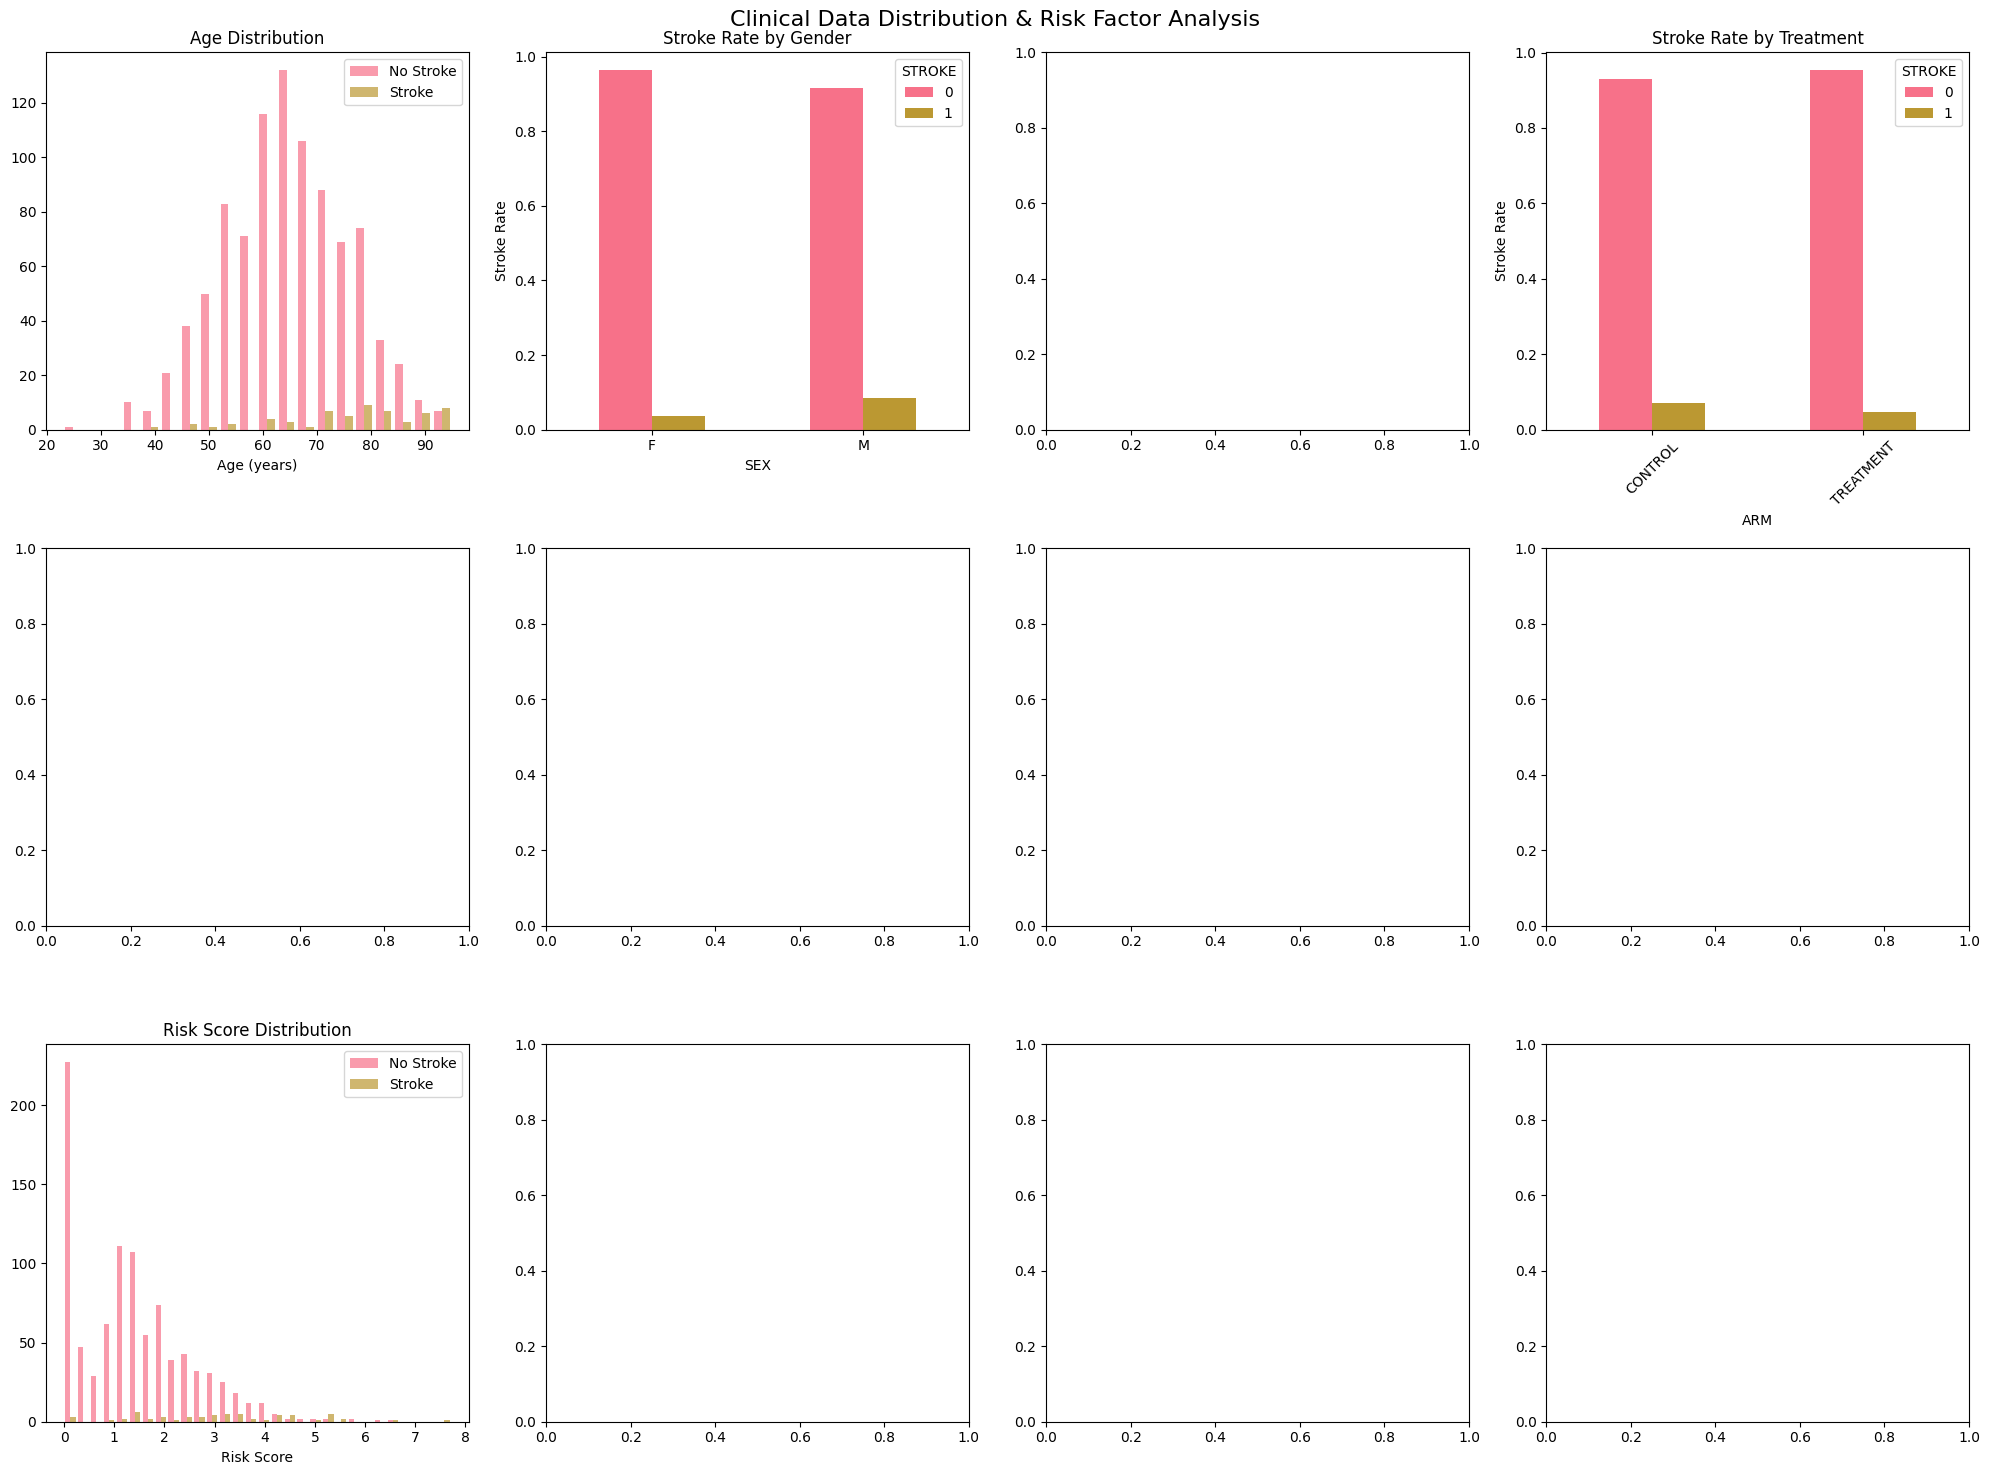


=== Clinical Summary Statistics ===
Overall stroke rate: 5.9%
Mean age: 65.3 ± 12.0 years

Stroke rates by demographic groups:
By Gender:
     count  sum   mean
SEX                   
F      543   20  0.037
M      457   39  0.085

By Treatment:
           count  sum   mean
ARM                         
CONTROL      490   35  0.071
TREATMENT    510   24  0.047

Building stroke prediction models...
Using 12 features for modeling
Features: ['AGE', 'VS_DIABP', 'VS_HR', 'VS_SYSBP', 'VS_TEMP', 'VS_WEIGHT', 'LB_CHOL', 'LB_CREAT', 'LB_GLUCOSE', 'LB_HDL', 'LB_LDL', 'LB_TRIG']
Final feature set: 21 features, 1000 samples
Final feature names: ['AGE', 'VS_DIABP', 'VS_HR', 'VS_SYSBP', 'VS_TEMP', 'VS_WEIGHT', 'LB_CHOL', 'LB_CREAT', 'LB_GLUCOSE', 'LB_HDL'] ...

Training Logistic Regression...
Logistic Regression AUC: 0.794

Training Random Forest...
Random Forest AUC: 0.764

Creating model evaluation plots...


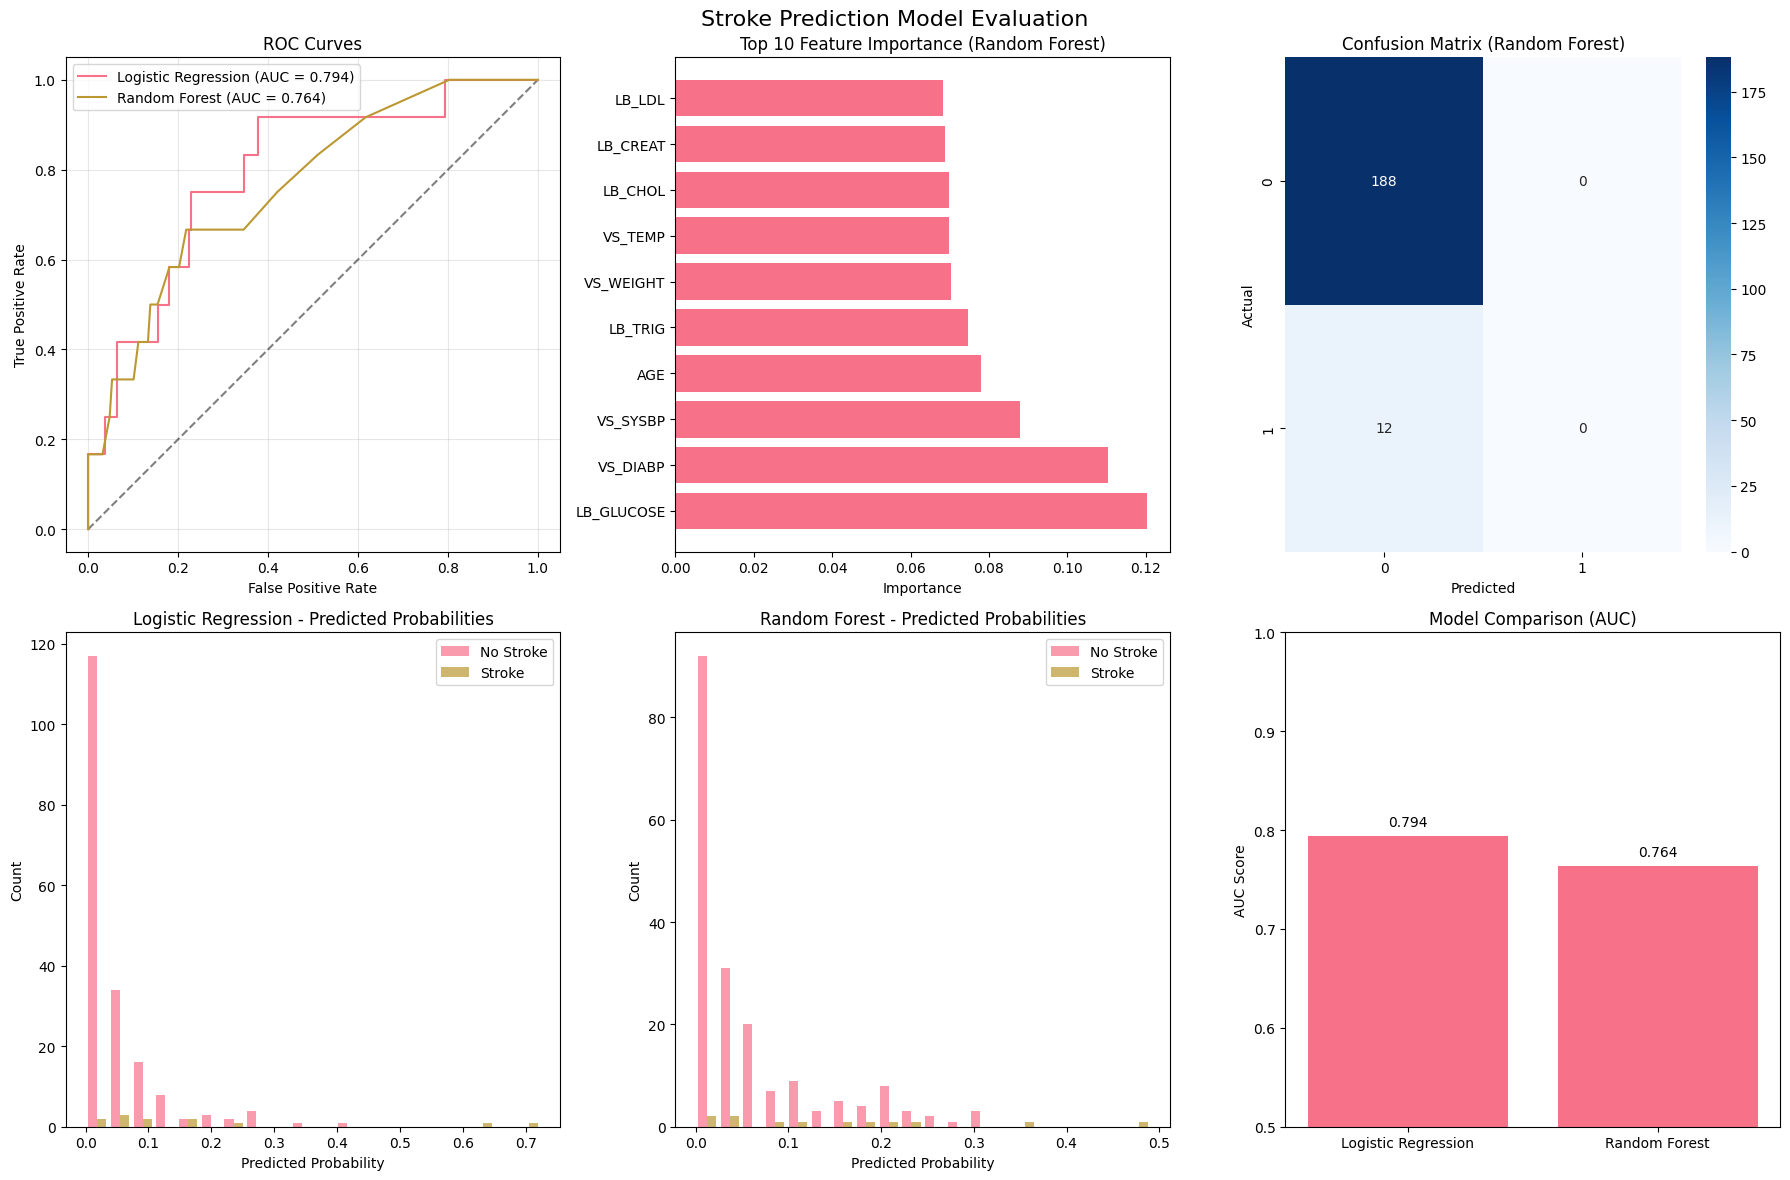

Using Random Forest for better handling of extreme values

Stroke Risk Calculator using Random Forest (AUC: 0.764)
Required features: ['AGE', 'VS_DIABP', 'VS_HR', 'VS_SYSBP', 'VS_TEMP', 'VS_WEIGHT', 'LB_CHOL', 'LB_CREAT', 'LB_GLUCOSE', 'LB_HDL', 'LB_LDL', 'LB_TRIG', 'SEX_F', 'SEX_M', 'RACE_ASIAN']

=== Training Data Ranges (for reference) ===
AGE: 23.0 - 95.0
VS_SYSBP: 106.9 - 162.6
LB_CHOL: 124.9 - 332.4
LB_GLUCOSE: 70.0 - 146.4

=== Example Stroke Risk Calculations ===

=== Debug Information ===
Input values: Age=72, Sex=M, SBP=150, Glucose=140, Chol=550
Input data shape: (1, 21)
Key feature values:
  AGE: 72
  VS_SYSBP: 150
  LB_CHOL: 550
  LB_GLUCOSE: 140
  SEX_M: 1
Using raw features (Random Forest)
Raw prediction probability: 0.340000
Final risk: 34.000%
Male, 72 years, SBP=150, Glucose=140, Cholesterol=550: 34.000% stroke risk
Female, 45 years, SBP=110, Glucose=90, Cholesterol=180: 0.000% stroke risk
Male, 65 years, SBP=130, Glucose=105, Cholesterol=200: 0.000% stroke risk

=== 

In [10]:
# Clinical Data Evaluation & Stroke Risk Prediction Model
# Run this AFTER the data generation script

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("=== Clinical Data Sanity Check & Model Evaluation ===\n")

# =============================================================================
# 1. Data Preparation & Feature Engineering
# =============================================================================

def prepare_modeling_dataset(df_dm, df_vs, df_lb, df_outcomes):
    """Prepare dataset for modeling by merging and aggregating clinical data"""
    
    print("Preparing modeling dataset...")
    
    # Aggregate vital signs (mean values per subject) 
    vs_pivot = df_vs.pivot_table(
        index='SUBJID',
        columns='VSTESTCD', 
        values='VSORRES',
        aggfunc='mean'  # Only mean, no std to avoid column conflicts
    )
    
    # Add prefix to distinguish VS from LB
    vs_pivot.columns = [f'VS_{test}' for test in vs_pivot.columns]
    vs_pivot = vs_pivot.reset_index()
    
    # Aggregate laboratory values
    lb_pivot = df_lb.pivot_table(
        index='SUBJID',
        columns='LBTESTCD',
        values='LBORRES', 
        aggfunc='mean'  # Only mean, no std to avoid column conflicts
    )
    
    # Add prefix to distinguish LB from VS
    lb_pivot.columns = [f'LB_{test}' for test in lb_pivot.columns]
    lb_pivot = lb_pivot.reset_index()
    
    # Merge all datasets
    modeling_data = df_dm.copy()
    modeling_data = modeling_data.merge(vs_pivot, on='SUBJID', how='left')
    modeling_data = modeling_data.merge(lb_pivot, on='SUBJID', how='left')
    modeling_data = modeling_data.merge(df_outcomes, on='SUBJID', how='left')
    
    print(f"✓ Modeling dataset prepared: {len(modeling_data)} subjects, {len(modeling_data.columns)} features")
    print("Available features:", [col for col in modeling_data.columns if 'VS_' in col or 'LB_' in col])
    return modeling_data

# =============================================================================
# 2. Clinical Data Visualization & Sanity Checks
# =============================================================================

def plot_clinical_distributions(df_modeling):
    """Create comprehensive clinical data visualizations"""
    
    print("Creating clinical data visualizations...")
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Clinical Data Distribution & Risk Factor Analysis', fontsize=16, y=0.98)
    
    # Age distribution by stroke
    axes[0,0].hist([df_modeling[df_modeling['STROKE']==0]['AGE'], 
                   df_modeling[df_modeling['STROKE']==1]['AGE']], 
                  bins=20, alpha=0.7, label=['No Stroke', 'Stroke'])
    axes[0,0].set_title('Age Distribution')
    axes[0,0].set_xlabel('Age (years)')
    axes[0,0].legend()
    
    # Gender and stroke
    stroke_by_gender = pd.crosstab(df_modeling['SEX'], df_modeling['STROKE'], normalize='index')
    stroke_by_gender.plot(kind='bar', ax=axes[0,1], rot=0)
    axes[0,1].set_title('Stroke Rate by Gender')
    axes[0,1].set_ylabel('Stroke Rate')
    
    # Blood pressure analysis
    if 'mean_SYSBP' in df_modeling.columns:
        axes[0,2].scatter(df_modeling['mean_SYSBP'], df_modeling['STROKE'], alpha=0.5)
        axes[0,2].set_title('Systolic BP vs Stroke')
        axes[0,2].set_xlabel('Systolic BP (mmHg)')
        axes[0,2].set_ylabel('Stroke (0/1)')
    
    # Treatment effect
    stroke_by_arm = pd.crosstab(df_modeling['ARM'], df_modeling['STROKE'], normalize='index')
    stroke_by_arm.plot(kind='bar', ax=axes[0,3], rot=45)
    axes[0,3].set_title('Stroke Rate by Treatment')
    axes[0,3].set_ylabel('Stroke Rate')
    
    # Laboratory values
    lab_features = [col for col in df_modeling.columns if 'mean_' in col and any(lab in col for lab in ['CHOL', 'GLUCOSE', 'HDL', 'LDL'])]
    
    for i, feature in enumerate(lab_features[:4]):
        if i < 4 and feature in df_modeling.columns:
            row, col = (i+4)//4, (i+4)%4
            if row < 3:
                df_modeling.boxplot(column=feature, by='STROKE', ax=axes[row,col])
                axes[row,col].set_title(f'{feature.replace("mean_", "").title()} by Stroke')
                axes[row,col].set_xlabel('Stroke Status')
    
    # Risk score distribution
    if 'RISK_SCORE' in df_modeling.columns:
        axes[2,0].hist([df_modeling[df_modeling['STROKE']==0]['RISK_SCORE'],
                       df_modeling[df_modeling['STROKE']==1]['RISK_SCORE']], 
                      bins=30, alpha=0.7, label=['No Stroke', 'Stroke'])
        axes[2,0].set_title('Risk Score Distribution')
        axes[2,0].set_xlabel('Risk Score')
        axes[2,0].legend()
    
    # Age vs Blood pressure (clinical relationship)
    if 'mean_SYSBP' in df_modeling.columns:
        scatter = axes[2,1].scatter(df_modeling['AGE'], df_modeling['mean_SYSBP'], 
                                   c=df_modeling['STROKE'], cmap='RdYlBu', alpha=0.6)
        axes[2,1].set_title('Age vs Systolic BP (colored by stroke)')
        axes[2,1].set_xlabel('Age (years)')
        axes[2,1].set_ylabel('Systolic BP (mmHg)')
        plt.colorbar(scatter, ax=axes[2,1])
    
    # Correlation heatmap of key clinical variables
    clinical_vars = ['AGE'] + [col for col in df_modeling.columns if 'mean_' in col][:6] + ['STROKE']
    clinical_vars = [var for var in clinical_vars if var in df_modeling.columns]
    
    if len(clinical_vars) > 2:
        corr_matrix = df_modeling[clinical_vars].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   ax=axes[2,2], fmt='.2f')
        axes[2,2].set_title('Clinical Variables Correlation')
    
    # Overall stroke rate by key risk factors
    if len(clinical_vars) > 3:
        # Create risk groups based on age
        df_modeling['AGE_GROUP'] = pd.cut(df_modeling['AGE'], 
                                         bins=[0, 55, 65, 75, 100], 
                                         labels=['<55', '55-65', '65-75', '75+'])
        age_stroke = df_modeling.groupby('AGE_GROUP')['STROKE'].mean()
        age_stroke.plot(kind='bar', ax=axes[2,3], rot=45)
        axes[2,3].set_title('Stroke Rate by Age Group')
        axes[2,3].set_ylabel('Stroke Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Print clinical summary statistics
    print("\n=== Clinical Summary Statistics ===")
    print(f"Overall stroke rate: {df_modeling['STROKE'].mean():.1%}")
    print(f"Mean age: {df_modeling['AGE'].mean():.1f} ± {df_modeling['AGE'].std():.1f} years")
    
    if 'mean_SYSBP' in df_modeling.columns:
        print(f"Mean systolic BP: {df_modeling['mean_SYSBP'].mean():.1f} ± {df_modeling['mean_SYSBP'].std():.1f} mmHg")
    
    print("\nStroke rates by demographic groups:")
    print("By Gender:")
    print(df_modeling.groupby('SEX')['STROKE'].agg(['count', 'sum', 'mean']).round(3))
    print("\nBy Treatment:")
    print(df_modeling.groupby('ARM')['STROKE'].agg(['count', 'sum', 'mean']).round(3))

# =============================================================================
# 3. Build and Evaluate Stroke Prediction Models
# =============================================================================

def build_stroke_prediction_models(df_modeling):
    """Build multiple ML models for stroke prediction"""
    
    print("\nBuilding stroke prediction models...")
    
    # Prepare features for modeling - Use corrected feature names
    feature_columns = []
    
    # Demographics
    feature_columns.extend(['AGE'])
    
    # Add vital signs features (corrected names)
    vs_features = [col for col in df_modeling.columns if col.startswith('VS_')]
    feature_columns.extend(vs_features)
    
    # Add lab features (corrected names)
    lab_features = [col for col in df_modeling.columns if col.startswith('LB_')]
    feature_columns.extend(lab_features)
    
    # Filter existing columns
    feature_columns = [col for col in feature_columns if col in df_modeling.columns]
    
    print(f"Using {len(feature_columns)} features for modeling")
    print("Features:", feature_columns)
    
    # Prepare data
    X = df_modeling[feature_columns].copy()
    y = df_modeling['STROKE'].copy()
    
    # Handle categorical variables
    categorical_features = ['SEX', 'RACE', 'ARM']
    for cat_feature in categorical_features:
        if cat_feature in df_modeling.columns:
            # Create dummy variables
            dummies = pd.get_dummies(df_modeling[cat_feature], prefix=cat_feature)
            X = pd.concat([X, dummies], axis=1)
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    print(f"Final feature set: {X.shape[1]} features, {X.shape[0]} samples")
    print("Final feature names:", X.columns.tolist()[:10], "...")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)
    
    # For comparison: Train both scaled (Logistic) and unscaled (Random Forest) models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    # Train and evaluate models
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'auc': auc_score,
            'y_pred_proba': y_pred_proba,
            'y_pred': y_pred,
            'scaler': scaler if name == 'Logistic Regression' else None,
            'features': X.columns.tolist()
        }
        
        print(f"{name} AUC: {auc_score:.3f}")
    
    return results, X_test, y_test

# =============================================================================
# 4. Model Evaluation Plots
# =============================================================================

def plot_model_evaluation(results, X_test, y_test):
    """Create comprehensive model evaluation plots"""
    
    print("\nCreating model evaluation plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Stroke Prediction Model Evaluation', fontsize=16)
    
    # ROC Curves
    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        axes[0,0].plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")
    
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate') 
    axes[0,0].set_title('ROC Curves')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Feature Importance (Random Forest)
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        feature_names = results['Random Forest']['features']
        
        # Get top 10 most important features
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        axes[0,1].barh(importance_df['feature'], importance_df['importance'])
        axes[0,1].set_title('Top 10 Feature Importance (Random Forest)')
        axes[0,1].set_xlabel('Importance')
    
    # Confusion Matrix (Random Forest)
    if 'Random Forest' in results:
        cm = confusion_matrix(y_test, results['Random Forest']['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2])
        axes[0,2].set_title('Confusion Matrix (Random Forest)')
        axes[0,2].set_xlabel('Predicted')
        axes[0,2].set_ylabel('Actual')
    
    # Prediction Probability Distributions
    for i, (name, result) in enumerate(results.items()):
        prob_no_stroke = result['y_pred_proba'][y_test == 0]
        prob_stroke = result['y_pred_proba'][y_test == 1]
        
        axes[1,i].hist([prob_no_stroke, prob_stroke], bins=20, alpha=0.7, 
                      label=['No Stroke', 'Stroke'])
        axes[1,i].set_title(f'{name} - Predicted Probabilities')
        axes[1,i].set_xlabel('Predicted Probability')
        axes[1,i].set_ylabel('Count')
        axes[1,i].legend()
    
    # Model comparison
    model_names = list(results.keys())
    auc_scores = [results[name]['auc'] for name in model_names]
    
    axes[1,2].bar(model_names, auc_scores)
    axes[1,2].set_title('Model Comparison (AUC)')
    axes[1,2].set_ylabel('AUC Score')
    axes[1,2].set_ylim(0.5, 1.0)
    
    for i, score in enumerate(auc_scores):
        axes[1,2].text(i, score + 0.01, f'{score:.3f}', ha='center')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. Clinical Risk Calculator
# =============================================================================

def create_stroke_risk_calculator(results, df_modeling):
    """Create a function to calculate stroke risk for new patients"""
    
    # Use Random Forest (better for extreme values) instead of Logistic Regression
    if 'Random Forest' in results:
        best_model_name = 'Random Forest'
        print("Using Random Forest for better handling of extreme values")
    else:
        best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
    
    best_model = results[best_model_name]['model']
    scaler = results[best_model_name]['scaler']
    feature_names = results[best_model_name]['features']
    
    print(f"\nStroke Risk Calculator using {best_model_name} (AUC: {results[best_model_name]['auc']:.3f})")
    print("Required features:", feature_names[:15])
    
    # Debug: Check training data ranges
    print("\n=== Training Data Ranges (for reference) ===")
    key_features = ['AGE', 'VS_SYSBP', 'LB_CHOL', 'LB_GLUCOSE']
    for feature in key_features:
        if feature in df_modeling.columns:
            print(f"{feature}: {df_modeling[feature].min():.1f} - {df_modeling[feature].max():.1f}")
    
    def predict_stroke_risk(age, sex, systolic_bp, glucose, cholesterol, hdl=50, 
                           ldl=130, creatinine=1.0, heart_rate=70, diastolic_bp=80,
                           race='WHITE', treatment='CONTROL', debug=False):
        """
        Calculate stroke risk for a patient using corrected feature names
        """
        
        # Create input dataframe with CORRECTED feature names
        input_data = pd.DataFrame({
            'AGE': [age],
            'VS_SYSBP': [systolic_bp],      # Corrected: VS_ prefix
            'VS_DIABP': [diastolic_bp],     # Corrected: VS_ prefix
            'VS_HR': [heart_rate],          # Corrected: VS_ prefix
            'LB_CHOL': [cholesterol],       # Corrected: LB_ prefix
            'LB_GLUCOSE': [glucose],        # Corrected: LB_ prefix
            'LB_HDL': [hdl],               # Corrected: LB_ prefix
            'LB_LDL': [ldl],               # Corrected: LB_ prefix
            'LB_CREAT': [creatinine]       # Corrected: LB_ prefix
        })
        
        # Add ALL categorical dummy variables
        # Gender
        input_data['SEX_F'] = 1 if sex == 'F' else 0
        input_data['SEX_M'] = 1 if sex == 'M' else 0
        
        # Race
        races = ['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE']
        for r in races:
            input_data[f'RACE_{r}'] = 1 if race == r else 0
            
        # Treatment
        input_data['ARM_CONTROL'] = 1 if treatment == 'CONTROL' else 0
        input_data['ARM_TREATMENT'] = 1 if treatment == 'TREATMENT' else 0
        
        # Add any missing features with 0 values
        for feature in feature_names:
            if feature not in input_data.columns:
                input_data[feature] = 0
        
        # Ensure exact column order and presence
        input_data = input_data.reindex(columns=feature_names, fill_value=0)
        
        if debug:
            print(f"\n=== Debug Information ===")
            print(f"Input values: Age={age}, Sex={sex}, SBP={systolic_bp}, Glucose={glucose}, Chol={cholesterol}")
            print(f"Input data shape: {input_data.shape}")
            print(f"Key feature values:")
            key_cols = ['AGE', 'VS_SYSBP', 'LB_CHOL', 'LB_GLUCOSE', 'SEX_M']
            for col in key_cols:
                if col in input_data.columns:
                    print(f"  {col}: {input_data[col].iloc[0]}")
        
        # Apply scaling and predict
        try:
            if scaler is not None and best_model_name == 'Logistic Regression':
                input_scaled = scaler.transform(input_data)
                risk_prob = best_model.predict_proba(input_scaled)[0, 1]
                if debug:
                    print(f"Using scaled features (Logistic Regression)")
            else:
                # Use Random Forest (no scaling needed, better for extreme values)
                risk_prob = best_model.predict_proba(input_data)[0, 1]
                if debug:
                    print(f"Using raw features (Random Forest)")
        
            if debug:
                print(f"Raw prediction probability: {risk_prob:.6f}")
                print(f"Final risk: {risk_prob*100:.3f}%")
                
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            risk_prob = 0.0
        
        return risk_prob
    
    return predict_stroke_risk

# =============================================================================
# 6. Execute Analysis Pipeline
# =============================================================================

if __name__ == "__main__":
    # Check if data exists (should be generated from previous script)
    try:
        # Load generated data
        df_dm = pd.read_csv('demographics.csv')
        df_vs = pd.read_csv('vital_signs.csv')
        df_lb = pd.read_csv('laboratory.csv') 
        df_outcomes = pd.read_csv('stroke_outcomes.csv')
        
        print("✓ Loaded generated clinical data")
        
        # Prepare modeling dataset
        df_modeling = prepare_modeling_dataset(df_dm, df_vs, df_lb, df_outcomes)
        
        # Clinical data visualization
        plot_clinical_distributions(df_modeling)
        
        # Build and evaluate models
        results, X_test, y_test = build_stroke_prediction_models(df_modeling)
        
        # Model evaluation plots
        plot_model_evaluation(results, X_test, y_test)
        
        # Create risk calculator
        predict_stroke_risk = create_stroke_risk_calculator(results, df_modeling)
        
        # Example usage
        print("\n=== Example Stroke Risk Calculations ===")
        
        # Example 1: High risk patient (with debug)
        risk1 = predict_stroke_risk(age=72, sex='M', systolic_bp=150, glucose=140, cholesterol=550, debug=True)
        print(f"Male, 72 years, SBP=150, Glucose=140, Cholesterol=550: {risk1:.3%} stroke risk")
        
        # Example 2: Low risk patient  
        risk2 = predict_stroke_risk(age=45, sex='F', systolic_bp=110, glucose=90, cholesterol=180)
        print(f"Female, 45 years, SBP=110, Glucose=90, Cholesterol=180: {risk2:.3%} stroke risk")
        
        # Example 3: Medium risk patient
        risk3 = predict_stroke_risk(age=65, sex='M', systolic_bp=130, glucose=105, cholesterol=200)
        print(f"Male, 65 years, SBP=130, Glucose=105, Cholesterol=200: {risk3:.3%} stroke risk")
        
        # Additional test cases for debugging
        print("\n=== Additional Test Cases ===")
        risk4 = predict_stroke_risk(age=80, sex='M', systolic_bp=180, glucose=200, cholesterol=300)
        print(f"Very high risk case: {risk4:.3%} stroke risk")
        
        risk5 = predict_stroke_risk(age=30, sex='F', systolic_bp=100, glucose=80, cholesterol=150)
        print(f"Very low risk case: {risk5:.3%} stroke risk")
        
        print(f"\n✓ Analysis complete! You can now use predict_stroke_risk() function for new patients.")
        
    except FileNotFoundError:
        print("❌ Data files not found. Please run the data generation script first.")
        print("The data generation script should create: demographics.csv, vital_signs.csv, laboratory.csv, stroke_outcomes.csv")

In [11]:
# Test your case with debugging
risk = predict_stroke_risk(
    age=72, 
    sex='M',
    systolic_bp=150,
    glucose=110, 
    cholesterol=220,
    debug=True  # This will show what's happening
)
print(f"\nStroke risk: {risk*100:.3f}%")


=== Debug Information ===
Input values: Age=72, Sex=M, SBP=150, Glucose=110, Chol=220
Input data shape: (1, 21)
Key feature values:
  AGE: 72
  VS_SYSBP: 150
  LB_CHOL: 220
  LB_GLUCOSE: 110
  SEX_M: 1
Using raw features (Random Forest)
Raw prediction probability: 0.080000
Final risk: 8.000%

Stroke risk: 8.000%


In [12]:
# Test your case with debugging
risk = predict_stroke_risk(
    age=72, 
    sex='M',
    systolic_bp=150,
    glucose=110, 
    cholesterol=550,
    debug=True  # This will show what's happening
)
print(f"\nStroke risk: {risk*100:.3f}%")


=== Debug Information ===
Input values: Age=72, Sex=M, SBP=150, Glucose=110, Chol=550
Input data shape: (1, 21)
Key feature values:
  AGE: 72
  VS_SYSBP: 150
  LB_CHOL: 550
  LB_GLUCOSE: 110
  SEX_M: 1
Using raw features (Random Forest)
Raw prediction probability: 0.240000
Final risk: 24.000%

Stroke risk: 24.000%
